<a href="https://colab.research.google.com/github/jlifferth/UQ-BIO-2022/blob/main/Module_4_3_MCMC_Analyses_With_Blanks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using MCMC for parameter inference from smFISH data

----------
## Qbio Summer School 2021

--------------
```
Author: Huy Vo
Contact Info: huydvo@colostate.edu

Copyright (c) 2021 Dr. Brian Munsky. 
Dr. Luis Aguilera, Will Raymond
Colorado State University.
Licensed under MIT License.
```

In [1]:
#@title Importing packages.
!pip install emcee  # For some autocorrelation calculations
import numpy as np  # For math
import scipy as sp  # For 
import sympy as sym # For some symbolic math
import scipy.stats as stats  # For probability distributions
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns # For histogram plotting
from tqdm import tqdm # For progress bars
import emcee as emcee # For some autocorrelation calculations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.6 MB/s 


# Monte Carlo Methods

## Sampling from a distribution using Monte Carlo methods (a very informal introduction)

In many analysis or modeling studies, we encounter some distribution $P(x)$ on some multi-dimensional space $E\subset \mathbb{R}^{d}$, and we want to understand something about that distribution.

For example, $P(x)$ could be the posterior distribution in a Bayesian analysis of some experimental data. 

Oftentimes, we only know $P(x)$ up to a constant factor $g(x)$, but we might not have an analytic formula for the CDF of $P(x)$. This means that the "inverse CDF" sampling method that we used for simple distributions no longer works.

Monte Carlo (MC) methods are suitable for this situation because they usually require us to know (or be able to estimate) only the relative function $g(x)$. This allows for Monte Carlo analyses to provide a convenient and powerful to understand such distributions.  

The basic steps of a MC method are:
1. Define an easilly simulated probability distribution on a space that encompases the domain of your problem of interest.
2. Generate a sequence of random samples from that simple probability distribution.
3. For each sample, perform some deterministic calculation to either _accept_ or _reject_ that sample.
4. Sum up all of your results. 

## Example: Using MC to estimate the number $\pi$.

Let's follow the steps above to create a MC method to calculate $\pi$.

__Steps 1-2__ - let's choose a 2D probability distrbution that is easy to generate random numbers.  In this case lets generate uniform on the square.

__Step 3__ - Count how many of the random number pairss are inside the unit circle.

__Step 4__ - Since the the fraction $f$ of samples in the circle should be the area of the circle ($\pi r^2 = \pi$) divided by the area of the square ($(2r)^2=4$, we can estimate $\pi$ as:

$$\pi = 4f$$

pi is approximately =  3.1112


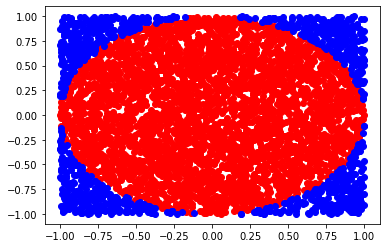

In [18]:
#Let's try it for different sample sizes.
N = 5000 # number of samples to use.

# use np.random.random to generate rv's.
rv = -1 + 2*np.random.rand(N,2)
# use logic to indicate which are inside the circle
inside = (rv[:,0]**2 + rv[:,1]**2) <1
# print(inside)

# plot the results
fig, ax = plt.subplots(1,1)
ax.scatter(rv[inside,0],rv[inside,1],color='r')
ax.scatter(rv[~inside,0],rv[~inside,1],color='b')
print('pi is approximately = ',str(4.0*sum(inside)/N))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


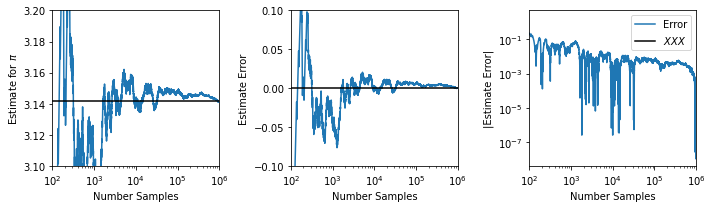

In [19]:
# How does MC error scale with the number of samples?
# Let's look at the error as a function of the number of samples:
N = 1000000
rv = -1 + 2*np.random.rand(N,2)
inside = (rv[:,0]**2 + rv[:,1]**2) <1
pi_est = 4.*np.cumsum(inside)/range(0,N)

fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 3)

ax[0].plot(range(0,N),pi_est )
ax[0].set_ylim([3.10,3.2])
ax[0].set_xscale('log')
ax[0].set_xlim([100,N])
ax[0].set_xlabel('Number Samples')
ax[0].set_ylabel(r'Estimate for $\pi$')
ax[0].axhline(np.pi, color="k")

ax[1].plot(range(0,N),pi_est-np.pi)
ax[1].set_ylim([-.1,.1])
ax[1].set_xscale('log')
ax[1].set_xlim([100,N])
ax[1].set_xlabel('Number Samples')
ax[1].set_ylabel(r'Estimate Error')
ax[1].axhline(0., color="k")

ax[2].plot(range(0,N),abs(pi_est-np.pi))
# ax[2].plot([1,N],XXX)
# ax[1].set_ylim([,.1])
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlim([100,N])
ax[2].set_xlabel('Number Samples')
ax[2].set_ylabel(r'|Estimate Error|')
ax[2].axhline(0., color="k")
ax[2].legend(['Error',r'$XXX$'])

fig.set_tight_layout(True)

## Example: Using MC to integrate a function.

Let's follow the steps again to create a MC method to calculate the integral of the function g(x,y) over the unit square.

__Steps 1-2__ Similar to last time, we can choose to generate uniform random numbers on a unit cube, i.e., triplets (x,y,z).

__Step 3a__ For each (x,y) random pair, we evaluate the function g(x,y) and store the answer.  

__Step 3b__ We then rescale all function evaluations between a minimum at zero to a maximum at one. We now find the fraction of times the re-scaled g(x,y) is less than the third random number z. 

__Step 4__ The approximate integral is then:

$$
\int_{x_0}^{x_1}dx \int_{y_0}^{y_1}dy g(x,y)\approx  \left(f\cdot g_{max} + (1-f)\cdot g_{min}\right)(x_1-x_0)(y_1-y_0)
$$

__Example__ Let's try it for $g(x,y) = x+y^2$ over $x\in(1,2.5)$ and $y\in (0,2)$, for which we can find the exact solution: 
$$
\int_{1}^{2.5}dx \int_{0}^{2}dy (x+y^2) = 
\int_{1}^{2.5}dx \left(2x+\frac{8}{3}\right)
=2.5^2-1+\frac{8}{3}(2.5-1) = 9.25
$$

In [26]:
def g_of_x_y(x,y):
  return x + y**2.0

N = 100000 # Number of samples to use
rv = np.random.random([N,3])

# Scale the rvs to the correct domain and compute g(x,y) over the full domain.
g = g_of_x_y(1.0+rv[:,0]*1.5, 0.0+2.0*rv[:,1])

# Find the minimum and maximums of g(x,y) and scale so it ranges between 0 and 1.
gmin = min(g); gmax = max(g)
gscaled = (g - gmin) / (gmax - gmin)
# print(gscaled)

# Count how many rv's are less than the function
inside = gscaled > rv[:,2]

# Approximate the volume under the curve as the appropriate
# fraction of the hypercube times the hypercube volume.
Area = 1.5*2.0 # the area of the entire domain (i.e., integral of 1 over x and y)
hypercube_volume = Area*(gmax-gmin) # the integral of the function with respect to the minimum of g(x,y). # this volume of the hypercube that encloses the entire function g(x,y) 
# at all sampled values of x,y
pedastal_volume = Area*gmin # the integral of the min(g) over the full domain.
int_g_aprox = hypercube_volume*np.sum(inside)/N + pedastal_volume

print('int is approximately = ',str(int_g_aprox))

int is approximately =  9.266161816204608


In [ ]:
#@title Callable function "MC_Integrate_Function" for later.
def MC_Integrate_Function(g,bounds,N):
  Nvar = bounds.shape[0]
  rv = np.random.random([N,Nvar+1])

  # Scale the rvs to the correct domain and compute g(x,y)
  for i in range(Nvar):
    rv[:,i] = bounds[i,0]+rv[:,i]*(bounds[i,1]-bounds[i,0]) 
  gval = g(rv)

  # Find the minimum and maximums of g(x,y) and scale.
  gmin = min(gval); gmax = max(gval)
  gscaled = (gval-gmin)/(gmax-gmin)

  # Count how many rv's are less than the function
  inside = rv[:,Nvar]<gscaled

  # Approximate the volume under the curve as the appropriate
  # fraction of the hypercube times the hypercube volume.
  Area = np.prod(bounds[:,1]-bounds[:,0])
  hypercube_volume = np.sum(inside)/N*(gmax-gmin)*Area
  pedastal_volume = gmin*Area

  # Sometimes we may want to visualize the results, so we will return the 
  #   the sampled points and successes as well as the result of 
  #   the integration a
  return hypercube_volume + pedastal_volume, rv, inside

# Example:
def g_of_x_y(x):
  return x[:,0] + x[:,1]**2.0

N = 100000
bounds = np.array([[1.,2.5],[0,2]])
int_g_aprox = MC_Integrate_Function(g_of_x_y,bounds,N)[0]
print('int is approximately = ',str(int_g_aprox))

int is approximately =  9.275957642382753


# Markov Chain Monte Carlo (MCMC) Methods

In the previous examples, we knew in advance what was the support of the distribution of interest, and it was straightforward to choose the right distribution domain for steps 1 and 2. 

Unfortunately, this is not always the case. Sometimes we need to figure out the domain as we go. For such problems we can introduce another technique called __Markov Chain Monte Carlo__.

A Markov Chain on the space $E$ is a collection of random vectors $X_1,X_2,\ldots$ taking values on $E$ such that the value of $X_{i+1}$ depends _only_ on the value of $X_{i}$ and not any other values. MCMC methods aim to design a Markov chain $\{X_i\}_{i=1}^{\infty}$ that have the following properties:
1. $X_n$ is approximately distributed as $P(x)$ as $n\to \infty$.
2. The chain is ergodic, meaning that the time averages are the same as the ensemble averages over a long time horizon.

The first property guarantees that we will have samples that are nearly as good as samples from the target $P(x)$ if we draw independent samples from $X_n$ for a large enough $n$. 

The second property guarantees that simulating a _single_ long trajectory of the process will give us the same distribution as drawing many long trajectories (to get to $X_n$ for a very large $n$).

## The Metropolis-Hastings algorithm
The Metropolis-Hastings algorithm is based on one such Markov chain. The main ingredient of the algorithm is a _proposal distribution_ $Q(x, \cdot)$. The algorithm starts with some initial point $X_0:=x_0$. At each step, the algorithm uses the proposal distribution to randomly generate a _candidate_ $x'$ for the next step. The algorithm then decides whether to accept $x'$ as the next state or simply stay at the current state for the next time step based on an acceptance ratio.

More precisely, let $X_i:=x$ be the current state at step $i$. The Metropolis-Hastings algorithm then performs the following substeps:
- Generate a candidate $x' \sim Q(x,\cdot)$.
- Compute the acceptance ratio $$r(x,x'):= \min\left\{1, \frac{g(x')Q(x',x)}{g(x)Q(x,x')}\right\}.$$
- Generate a uniform random number $u\sim U(0,1)$. If $u \leq r(x,x')$, set $X_{i+1}:=x'$ (accept), otherwise set $X_{i+1}:=x$ (reject). Increase the counter $i\leftarrow i+1$ and repeat until we have generated a sufficiently long trajectory.

When we have a _symmetric_ proposal, meaning that $Q(x',x)=Q(x,x')$, then the algorithm is often called the Metropolis algorithm, in which case the ratio amounts to comparing the target probability densities between the current state and the proposed state. A usual choice of a symmetric proposal is to let $Q(x,\cdot)$ be a Gaussian distribution centered at $x$. We will code this up below. 

__Note__- Because probabilities are often very small numbers between zero and one, it is often much more convenient to write and compare logarithms of probabilities. When we do this, the acceptance criteria changes from 
$$r(x,x'):= \min\left\{1, \frac{g(x')Q(x',x)}{g(x)Q(x,x')}\right\}$$
to
$$\log(r(x,x')):= \min\left\{0, \log(g(x')Q(x',x))-\log(g(x)Q(x,x')\right\}$$.  

To use this condition, we compare $f_{new} = \log(g(x')Q(x',x))$ with $f_{old} = \log(g(x)Q(x,x')$.  

If $f_{new}\ge f_{old}$, we accept and move on to the next step.

If $f_{new}<f_{old}$, we draw a uniform random number $r$ and accept if $\log(r) \le f_{new} - f_{old}$




### Aside: Using Bayes' Rule to Sample Posterior Dstributions

Please remember that like the other MC methods above, the Metropolis and Metropolis Hastings algorithsms result in a set of samples taken from the desired distribution. To get the actual distribution, we need to assign the appropriate scale. For example if our histogram of $Z$ samples is $g(x)$, then we can approximate:

$P(x) = \frac{1}{Z}g(x)$

As mentioned above, this Metropolis and Metropolis Hastings Algorithms are often used in Bayesian parameter estimation.  In this process, we are given (or can guess) a prior on the parameters:

__Prior__: $p(\theta)$.

And we can compute the likelihood of observed data given a model with some set of parameters:

__Likelihood__: $L(D|\theta)$.

We then wish to compute (via Bayes' rule) the posterior distrbution of the parameters given the data:

__Posterior__: $P(\theta | D) = \frac{p(\theta)L(D|\theta)}{\int_{E}{p(\theta)L(D|\theta)}}$

In general, we do not know the denominator of this expression, but we do know that the full expression must integrat to exactly one.  Therefore, we can estimate:

 $P(\theta | D) = \frac{1}{Z}p(\theta)L(D|\theta)$

You will see this again later in this notebook, but it is important enough to repeat multiple times.

## Coding up the Metropolis in Python

In [27]:
# This section creates a function for the metropolis algorithm.
from typing import Callable 
def metropolis(log_target_pdf: Callable[[np.ndarray], float], 
               start: np.ndarray,   # The initial parameter set
               chain_len: int,      # The length of the chain
               cov_matrix: np.ndarray, # The covariance matrix of the proposal distribution
               rng=np.random.default_rng()): # Seed for random number generator
  
  # initialize sample chains, likelihoods, acceptance rate
  pdim = len(start)
  samples = np.zeros((chain_len, pdim))
  log_target_pdfs = np.zeros((chain_len,))
  samples[0,:] = start[:]
  nacc = 0

  # compute initial log-likelihood function for samples[0,:]
  log_target_pdfs[0] = log_target_pdf(samples[0,:]
    
  pbar = tqdm(range(chain_len-1))  # Progress bar
  for i in pbar:    

      # propoise new parameter value based on multivariate normal with given covariance matrix        
      xpropose = rng.multivariate_normal(samples[i,:], cov_matrix)      
      
      # compute the new log likelihood
      logpipropose = XXX
      
      logu = np.log(rng.uniform(0, 1))   # acceptance level 
      if logu <= logpipropose - log_target_pdfs[i]: # equivalent to u <= g(x')/g(x)
          # Accept and record new parameer set
          samples[i+1, :] = xpropose[:]
          log_target_pdfs[i+1] = logpipropose
          nacc += 1
      else:
          # Reject and keep old parameer set
          samples[i+1, :] = samples[i, :]
          log_target_pdfs[i+1] = log_target_pdfs[i]
      
      # update progress bar
      pbar.set_postfix(acceptance_rate=nacc/(i+1))      
  pbar.close()

  return samples, log_target_pdfs  

Can you update the code above to allow for a burnin period (easy)?  

What about to allow for thinning of samples in the output data (easy)?

How could you change this algorithm to the Metropolis Hastings Algorithm for a non-symmetric proposal distribution (harder)?

## Example: Using Metropolos Algorithm to Sample a Univariate Normal Distribution

In [28]:
# The log of the PDF for a normalized normal distribution (mu = 0, sigma^2 = 1).
def normal_log_pdf(x):
  return -x*x/2.0 # This is the unnomralized version

# Run the metrolips algorithm to sample the normal distribution
normal_chain, log_target = metropolis(normal_log_pdf, [-1.0], 10000, np.array([[1.0]]))

NameError: ignored

In [29]:
# Draw samples using the builtin numpy.random.normal function
normal_iid = np.random.normal(size=(10000,1))

NameError: ignored

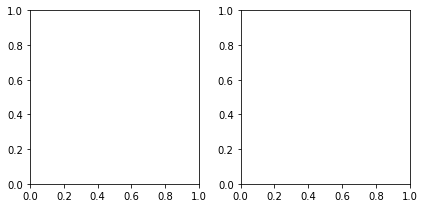

In [30]:
#@title Compare MCMC and direct sampling to true distribution { run: "auto" }
n_samples = 7700 #@param {type:"slider", step: "100", max: "10000"}

fig, ax = plt.subplots(1,2)
fig.set_size_inches(6, 3)
fig.set_tight_layout(True)

# plot results for probability density
bins = np.linspace(min(normal_chain[:,0]),max(normal_chain[:,0]),30).T
ax[0].hist(normal_chain[:n_samples,:], bins=bins, density=True, alpha=0.5, color="blue", label="MCMC")
ax[0].hist(normal_iid[:n_samples,:], bins=bins, density=True, alpha=0.5, color="red", label="Direct sampling")
ax[0].plot(np.linspace(-3, 3, 100), sp.stats.norm.pdf(np.linspace(-3,3,100), loc=0, scale=1), 
        color="crimson", lw=3, label="Exact")
ax[0].set_xlabel('value')
ax[0].set_ylabel('(empirical) density')

ax[0].legend()

# plot results for cumulative probability distribution
ax[1].hist(normal_chain[:n_samples,:], bins=bins, density = True, cumulative=True, alpha=0.5, color="blue", label="MCMC")
ax[1].hist(normal_iid[:n_samples,:], bins=bins, density = True, cumulative=True, alpha=0.5, color="red", label="Direct sampling")
ax[1].plot(np.linspace(-3, 3, 100), sp.stats.norm.cdf(np.linspace(-3,3,100), loc=0, scale=1), 
        color="crimson", lw=3, label="Exact")
ax[1].set_xlabel('value')
ax[1].set_ylabel('(empirical) cumulative distribution')
ax[1].legend()

Can you make a plot to compare the accuracy versus the number of samples for these two approaches (moderate)? 

## Example: Using Metropolis Algorithm To Integrate a Function g(x,y).

Let's revisit the integration of g(x,y), but this time let's use the Metropolis Algorithm and look at a more complex function:

$$ g(x,y)  = h(x,y)\cdot p(x,y) = (2x+3xy)\cdot \exp\left(-6(x-1)^2-3(y-1.8)^2 \right)$$

As you can see, we have broken the function into two parts $h(x,y)$ and $p(x,y)$.  This is broken up such that we know (or can closely approximate) the integral of $p(x,y)$. For example if $p(x,y)$ is a probability distribution, then we know that its intergral is exactly one.  In our case $p(x,y)$ is almost a multivariate gaussian -- it is just missing a normalization constant $\sqrt{\det(2\pi\Sigma)} = \sqrt{(2\pi)^2/72}$.


In [ ]:
# First, let's set up the problem.
bounds = np.array([[-2.,3],[-4.,6]])
def p(x): return np.exp(-6*(x[:,0]-1)**2-3*(x[:,1]-1.8)**2)
def logp(x): return -6*(x[0]-1)**2-3*(x[1]-1.8)**2
def h(x): 
  # We change h to be zero if we are outside of the domain of the probelem.
  TMP = np.array([(x[:,i]>=bounds[i,0])&(x[:,i]<=bounds[i,1]) for i in range(bounds.shape[0])])
  inBounds = np.min(np.min(TMP,axis=0))
  return (2*x[:,0]+3*x[:,0]*x[:,1])*inBounds
def g(x): return p(x)*h(x)

integral_of_p = np.sqrt((2.*np.pi)**2*(1/12*1/6))  # note that this is sqrt(det(2*pi*Sigma)), where Sigma is the covariance matrix.

In [ ]:
N_MCMC = 5000 #@param
# chain, log_target = metropolis(logp, [0.5,0.5], N, np.array(.5*np.eye(2)))
approx = 1./N_MCMC*sum(h(chain))
print('MH estimate = ',str(integral_of_p*approx))

# Let's compare to the direct MC approach from before.
N_MC = 100000000 #@param
int_g_aprox, rv, inside = MC_Integrate_Function(g,bounds,N_MC)
print('MC estimate = ',str(int_g_aprox))

showPlot = False #@param
if showPlot:
  # Plot the samples to compare
  fig, ax = plt.subplots(1,2)
  fig.set_size_inches(6, 3)
  fig.set_tight_layout(True)
  ax[0].scatter(chain[:,0],chain[:,1])
  ax[1].scatter(rv[~inside,0],rv[~inside,1],color='b')
  ax[1].scatter(rv[inside,0],rv[inside,1],color='r')
  [ax[i].set_xlim(bounds[0,:]) for i in range(2)]
  [ax[i].set_ylim(bounds[1,:]) for i in range(2)]


MH estimate =  5.545459496952768
MC estimate =  5.47824007132298


Try this out for a couple different functions whose integrals you already know and check for yourself that it works (moderate).  

# Using MCMC for Bayesian Analyses

In the previous problem, you learned to integrate some function $g(\mathbf{x}) = h(\mathbf{x})p(\mathbf{x})$ by running a MCMC to generate samples from a function $p(\mathbf{x})$. You could then compute the integral by averaging $h(\mathbf{x})$ over those samples and scaling the final result by the integral of $p(\mathbf{x})$.  

One particular case that is often very interesting is when $p(\mathbf{x})$ is a probability density function (remember that the integral of any probability distributon $p(\mathbf{x})$ is one). Let's see how this fact can be used for Baysian Model Inference.

__Bayes' Theorem__

Let $\mathbf{D}$ be some observations, such as the single-cell measurements we have been discussing over the past two weeks.

Consider a model with unknown parameters $\Lambda$ that predicts the likelihood of observing such data, $P(\mathbf{D}|\Lambda)$. For example, this could be some analytical expression for an assumed distribution (e.g., binomial, gaussian, etc.) or this could be the CME/FSP analysis that we explored previously.

Suppose also that we have some __prior__ information (guesses) about the parameters - maybe we have fit similar models in the past and believe that $\Lambda$ should be distributed according to some distribution $P(\Lambda)$. 

From this information, Bayes' Theorem tells us that:
$$
P(\Lambda|\mathbf{D})P(\mathbf{D}) = P(\mathbf{D}|\Lambda)P(\Lambda),
$$
where $P(\mathbf{D}) = \int{p(\Lambda)L(D|\Lambda)}d\Lambda$ is the probability of the data (which we don't know and we won't even need to know!).  

We want to know the probability distribution of the model parameters, so let's rearrange a bit: 
$$
P(\Lambda|\mathbf{D}) = \frac{P(\mathbf{D}|\Lambda)P(\Lambda)}{P(\mathbf{D})}.
$$
Here, $P(\Lambda|\mathbf{D})$ is known as the __posterior probability distribution__ of the parameters.  Because it is a probability distribution, we know it integrates to one, and we can treat $P(\mathbf{D})$ as an integration constant (i.e., we can just ignore it!):
$$
P(\Lambda|\mathbf{D}) \sim P(\mathbf{D}|\Lambda)P(\Lambda).
$$

Using the Metropolis Algorithm, we can now sample this probability distribution, and calculate expectations of different functions over this random variable.  Let's try with a couple examples:

## Example: MCMC for Bayesian Analysis of Coin Toss Experiments

### Simulating some Coin Toss Data

We will use the example of a _biased_ coin in which the true probability of observing head will be $p:=\pi/4$.  (See above to understand why we chose this -- I guess we should call it a dart throwing experiment instead of a coint toss experiment.)

In [ ]:
P_TRUE = np.pi/4.

In the following, we use `numpy` to simulate the outcome of $100$ independent flips.

Text(0, 0.5, 'Number with each result')

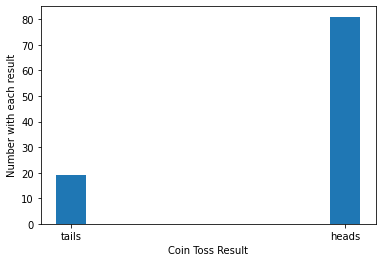

In [ ]:
# Generate 100 simulated coin tosses and plot the number of heads.
fig, ax = plt.subplots(1,1)
rng = np.random.default_rng(0)
data = rng.choice(2, p = (1-P_TRUE, P_TRUE), size=(100,))
ax.hist(data)
ax.set_xticks([0.05,0.95])
ax.set_xticklabels(['tails','heads'])
ax.set_xlabel(r'Coin Toss Result')
ax.set_ylabel(r'Number with each result')

### Choosing Convenient Parameter Definitions

When doing parameter searches like the MHA, it is more conveneint to search over the set of all real numbers. So, for convenience let's define a couple functions to transform the between the original bounded parameter space $p\in(0,1)$ and an unbounded space $\theta\in(-\infty, \infty)$.  

For this, let's _sigmoid_ function, $\theta\rightarrow p$ by 
$$
p:=\mathrm{sigmoid}(\theta):= \frac{1}{1+\exp(-\theta)}
$$

Text(0, 0.5, 'Original parameter, p')

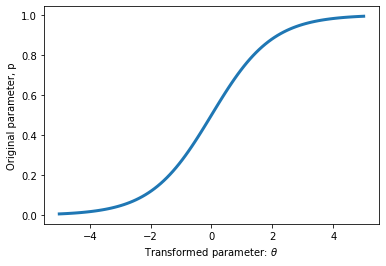

In [ ]:
# define a sigmoid function
def sigmoid(theta):
  return 1.0/(1.0 + np.exp(-theta))

# plot the sigmoid for p vs \theta.
theta = np.linspace(-5, 5, 100)
plt.plot(theta, sigmoid(theta),linewidth=3)
plt.xlabel(r'Transformed parameter: $\theta$')
plt.ylabel(r'Original parameter, p')

The inverse of the sigmoid is the logit function.

Text(0.5, 0, 'Original parameter, p')

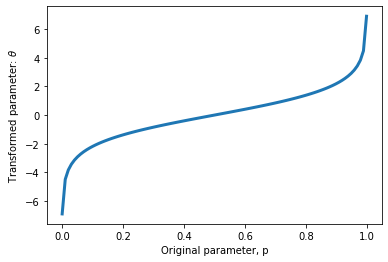

In [ ]:
# The logit function
def logit(p):
  return np.log(p/(1-p))

# We use the logit function to plot theta vs. p
p = np.linspace(0.001, 0.999, 100)
plt.plot(p, logit(p),linewidth=3)
plt.ylabel(r'Transformed parameter: $\theta$')
plt.xlabel(r'Original parameter, p')

### Defining the Likelihood Function P(D|M)


Recall from Module 2.1 that the probability mass function for a Bernoulli Random Variable is:
$$
P(n|p) = \left\{ \begin{array}{ll} 
p &\text{for n=1 (''heads'')} \\
1-p &\text{for n=0 (''tails'')} \\
\end{array} \right\}
$$
For a total of $N$ coin flips, the likelihood to get $D$ heads and $(N-D)$ tails is:
$$
P(D|p) = p^{D}(1-p)^{N-D},
$$
and the log-likelihood is:
$$
\log P(D|p) = D\log(p) + (N-D)\log(1-p).
$$

Text(0, 0.5, 'Log Likelihood of Data')

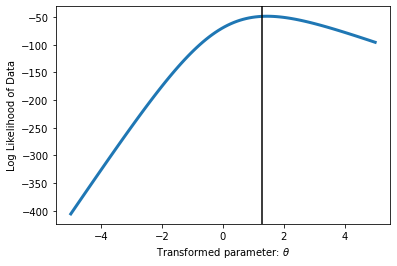

In [ ]:
# Define the log likelihood function for the coin toss.
def coin_toss_loglike(theta: float, data: np.ndarray)->float:
  p = sigmoid(theta)
  return XXX

# Plot the log likelihood versus the transformed parameter theta.
theta = np.linspace(-5, 5, 100)
theta_true = logit(P_TRUE)
plt.plot(theta, coin_toss_loglike(theta, data),linewidth=3)
plt.axvline(theta_true, color="k")
plt.xlabel(r'Transformed parameter: $\theta$')
plt.ylabel(r'Log Likelihood of Data')

### Formulating a Prior on the Probability of Heads

Before we do any experiment, we may have some prior belief about the parameters in the process that we are examining. 

For this coin toss example, let's assume we don't know much -- $p$ could be any number uniformly distributed between zero and one.  That is, our prior is simply:

$$P(p) = f_P(p) = 1.$$

To get the prior in the space of the transformed variable, we recall from Module 2.1.A that we need to transform the probability distribution. 

Above, we defined the invertible transformation: 
$$p := g(\theta) = \frac{1}{1+\exp(-\theta)},$$
<!-- $$\theta := g^{-1}(p) = \log\left(\frac{p}{1-p}\right)$$ -->
for which we can take the derivatives:
<!-- $$\frac{\partial}{\partial p}g^{-1}(p) = \frac{-1}{p^2-p}$$ -->
$$\frac{\partial}{\partial \theta}g(\theta) = \frac{\exp(-\theta)}{{\left(\exp(-\theta)+1\right)}^2}.$$

Thus, the transformation of the prior distribution is:
<!-- $$
f_P(p) = f_\Theta(g^{-1}(p))\left|\frac{\partial}{\partial p}g^{-1}(p)\right| = 
\frac{f_\Theta\left(\log\frac{p}{1-p} \right)}{p-p^2},
$$ -->
$$
f_\Theta(\theta) = f_P(g(\theta))\left|\frac{\partial}{\partial \theta}g(\theta)\right| = \frac{\exp(-\theta)}{{\left(\exp(-\theta)+1\right)}^2}
,
$$
where the function $f_{\Theta}$ is now the assumed prior on the transformed variable. For later, it will be convienient to take the log-PDF:
$$
\log f_\Theta(\theta) = -\theta - 2 \log\left(\left(\exp(-\theta)+1\right)\right).
$$
<!-- The log pdf of the transformed distribution is:
$$
\log f_P(p) = 
\log \left(f_\Theta\left(\log\frac{p}{1-p} \right)\right) - \log(p-p^2),
$$ -->

Let's make a plot:

Text(0, 0.5, 'Log PDF of Prior')

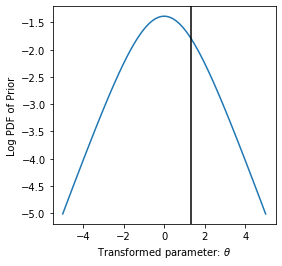

In [ ]:
# Define prior on transformed parameter space:
def coin_toss_logprior(theta: float)->float:
  return XXX

# Plot the prior distribution in the transformed parameter space.
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4, 4)
theta = np.linspace(-5, 5, 100)
theta_true = logit(P_TRUE)
ax.plot(theta, coin_toss_logprior(theta))
ax.axvline(theta_true, color="k")
ax.set_xlabel(r'Transformed parameter: $\theta$')
ax.set_ylabel(r'Log PDF of Prior')

Just to check our math, we can find the reverse transformation of the prior distribution. 
$$\theta := g^{-1}(p) = \log\left(\frac{p}{1-p}\right),$$
for which we can take the derivatives:
$$\frac{\partial}{\partial p}g^{-1}(p) = \frac{-1}{p^2-p}.$$
We can now substitute this into the change of variables for the prior distribution:
$$
f_P(p) = f_\Theta(g^{-1}(p))\left|\frac{\partial}{\partial p}g^{-1}(p)\right| = 
\frac{f_\Theta\left(\log\frac{p}{1-p} \right)}{p-p^2},
$$

where the function $f_{\Theta}$ is now the assumed prior on the transformed variable. Let's check that this all works out (we should get a flat prior after reversing the transformation).

Text(0, 0.5, 'Log PDF of Prior')

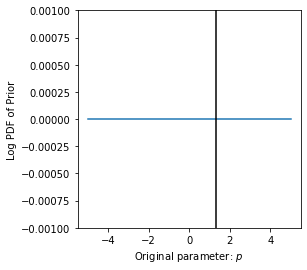

In [ ]:
# And let's make sure our transformation was correct by performing the reverse transformation:
def coin_toss_logprior_P(p: float)->float:
  return XXX

# Plot the prior distribution in the original parameter space.
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4, 4)
p = np.linspace(0.01, 0.99, 100)
theta_true = logit(P_TRUE)
ax.plot(theta, coin_toss_logprior_P(p))
ax.axvline(theta_true, color="k")
ax.set_xlabel(r'Original parameter: $p$')
ax.set_ylim([-0.001,0.001])
ax.set_ylabel(r'Log PDF of Prior')

### Run Metropolis Algorithm to Approximate Samples from the Posterior

From Bayes' Theorem, we know that the posterior distribution is proportional to the product of the likelihood and the prior:
$$P(𝚲|D) = \frac{P(D|𝚲)P(𝚲)}{P(D)},$$
where $P(D)$ is some normalization constant that we do not need to know.  Therefore, the log-posterior is:
$$\log P(𝚲|D) = \log P(D|𝚲) + \log P(𝚲) - \log P(D)$$

We can ignore $\log P(D)$ because it is a constant that does not depend on any of the parameters, and we now have everything we need to sample from the posterior distribution:

In [ ]:
# Define the log posterior as the sum of the log-liklihood and the log-prior
def log_target(theta):
  return XXX + XXX # log of the unnormalized posterior density

Nchain = 2000
InitialGuess = [-2.0]
# Let's run four chains, all starting wiht the same guess but using different step sizes 
chain_0, log_target_0 = metropolis(log_target, InitialGuess, Nchain, np.array([[1.0e-4]]))  
chain_1, log_target_1 = metropolis(log_target, InitialGuess, Nchain, np.array([[1.0]]))
chain_2, log_target_2 = metropolis(log_target, InitialGuess, Nchain, np.array([[1000.0]]))

  0%|          | 0/1999 [00:00<?, ?it/s, acceptance_rate=0.0667]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
100%|██████████| 1999/1999 [00:05<00:00, 380.29it/s, acceptance_rate=0.01]


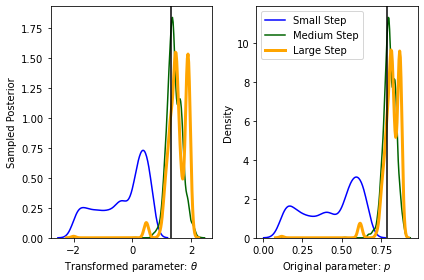

In [ ]:
# Plot the posterior, first in the transformed parameter (theta) space.
fig, ax = plt.subplots(1,2)
sns.kdeplot(chain_0[:,0], ax=ax[0], color="blue")
sns.kdeplot(chain_1[:,0], ax=ax[0], color="darkgreen")
sns.kdeplot(chain_2[:,0], ax=ax[0], color="orange", lw=3)

ax[0].axvline(theta_true, color="k")
ax[0].set_xlabel(r'Transformed parameter: $\theta$')
ax[0].set_ylabel(r'Sampled Posterior')

# Now to plot the posterior first in the original parameter space.
sns.kdeplot(sigmoid(chain_0[:,0]), ax=ax[1], color="blue")
sns.kdeplot(sigmoid(chain_1[:,0]), ax=ax[1], color="darkgreen")
sns.kdeplot(sigmoid(chain_2[:,0]), ax=ax[1], color="orange", lw=3)

ax[1].axvline(P_TRUE, color="k")
ax[1].set_xlabel(r'Original parameter: $p$')
ax[1].legend(['Small Step','Medium Step','Large Step','True Value'])
fig.tight_layout()

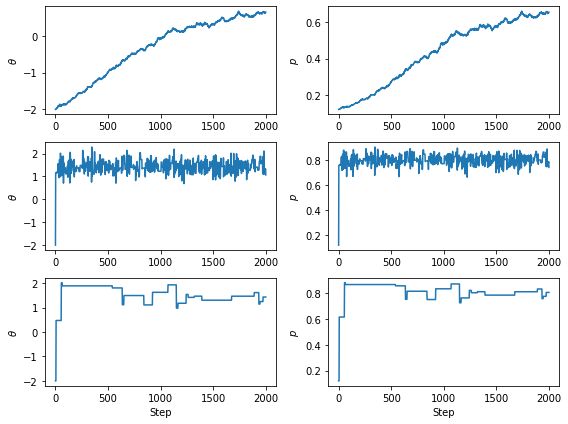

In [ ]:
# Now, let's examine the MCMC chains to see how well they have mixed.

# Put the chains in a list.
chains = [chain_0, chain_1, chain_2]

# Plot each of the chains
fig, axs = plt.subplots(3,2)
fig.set_size_inches(8, 6)
fig.set_tight_layout(True)
for i in range(3):
  axs[i,0].plot(chains[i])
  axs[i,1].plot(sigmoid(chains[i]))

# Add axes labels
for ax in axs[2,:]:
  ax.set_xlabel("Step")
for ax in axs[:,0]:
  ax.set_ylabel(r"$\theta$")
for ax in axs[:,1]:
  ax.set_ylabel(r"$p$")

fig.savefig('mcmc_proposal_performance.png', dpi=400, bbox_inches="tight")

Can you add a new section that plots the convergence of the error compared to the true value as a function of the number of samples.

# The adaptive Metropolis algorithm

We just saw that the convergence efficiency of the Metropolis Algorithm depends on the size of the proposal distribution.  This can be tuned during the chain.

In [ ]:
# Here we introduce an adaptive Metropilis algorithm that tunes the covariance matrix for the proposal distribution.
from typing import Callable 
def adaptive_metropolis(log_target_pdf: Callable[[np.ndarray], float], 
               start: np.ndarray, 
               chain_len: int, 
               cov_matrix: np.ndarray, 
               rng=np.random.default_rng()):

  # initialize sample chains, likelihoods, acceptance rate
  pdim = len(start)
  samples = np.zeros((chain_len, pdim))
  log_target_pdfs = np.zeros((chain_len,))
  samples[0,:] = start[:]
  nacc = 0

  # compure log-likeihood of first guess
  log_target_pdfs[0] = log_target_pdf(samples[0,:])  

  # open progress bar
  pbar = tqdm(range(chain_len-1))
  for i in pbar:  
      # propose new parameter set      
      xpropose = rng.multivariate_normal(samples[i,:], cov_matrix)      
      
      # compute new log-L
      logpipropose = log_target_pdf(xpropose)
      
      logu = np.log(rng.uniform(0, 1))   # acceptance criteria
      if logu <= logpipropose - log_target_pdfs[i]:
          # Accept and append chain with new parameters.
          samples[i+1, :] = xpropose[:]
          log_target_pdfs[i+1] = logpipropose
          nacc += 1
      else:
          # Reject and append chain with previous parameters.
          samples[i+1, :] = samples[i, :]
          log_target_pdfs[i+1] = log_target_pdfs[i]
      
      # update the covariance matrix based on previous samples.
      if i > 1:
        cov_matrix = np.cov(samples[0:i+1, :], None, rowvar=False) + 1.0e-6 * 2.4**2.0/ pdim * \
                            np.eye(pdim)
      # update progress bar
      pbar.set_postfix(acceptance_rate=nacc/(i+1))

  return samples, log_target_pdfs

In [ ]:
chain_adaptive, log_target_adaptive = adaptive_metropolis(log_target, [-2.0], 2000, np.array([[1.0e-4]]))

NameError: ignored

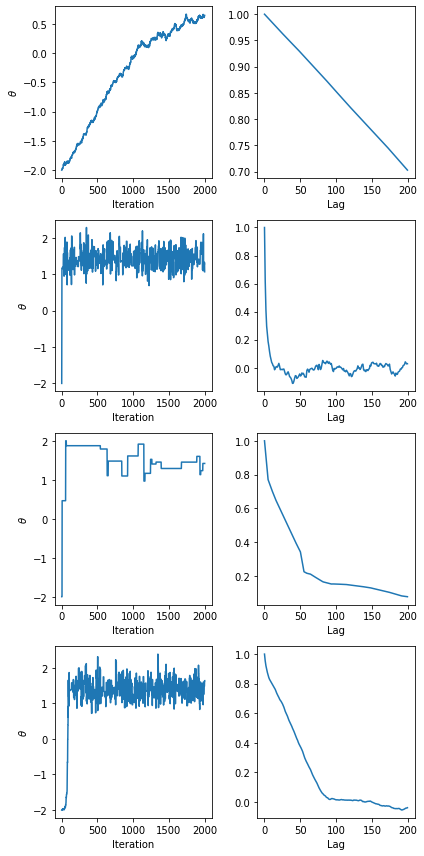

In [ ]:
# Now let's examine the chains to see how well they have mixed.
fig, axs = plt.subplots(4,2)
fig.set_size_inches(6, 12)
fig.set_tight_layout(True)

chains = [chain_0, chain_1, chain_2, chain_adaptive]

for i in range(len(chains)):
  axs[i,0].plot(chains[i])  
  axs[i,1].plot(emcee.autocorr.function_1d(chains[i][:,0])[:200])
  axs[i,1].set_xlabel("Lag")

for ax in axs[:,0]:
  ax.set_xlabel("Iteration")
  ax.set_ylabel(r"$\theta$")

# Estimating the Effective Sample Size

In the first few MC analyses, we used completely independent samples.  We saw that the error in our calculations scaled with $1/\sqrt{N}$.  

But for the Metropolis Algorithm, we know that each new proposal is dependent on the current value of the parameters.  

Now that we have run a few MA simulations, let's explore what are our effective sample sizes (ESS)

The ESS is estimated by:
$$
ESS = \frac{N}{\tau_f},
$$
where $\tau_f$ is the _integrated autocorrelation time_ in terms of the number of steps of the MCMC routine. $\tau_f$ is defined:
$$
\tau_f = \sum_{\tau=-\infty}^{\infty}\rho_f(\tau) = 1 + 2\sum_{\tau=1}^\infty \rho_f(\tau)
$$
where $\rho(\tau)$ is the autocorrelation.  Because the autocorrelation is very noisy for long lags due to smaller sample numbers, this is often truncated:
$$
\tau_f = 1 + 2\sum_{\tau=1}^M \rho_f(\tau)
$$
Let's try it.





In [ ]:
# Estimate the integrated autocorrelation time and the effective sample sizes.
tau = np.zeros(4); ESS = np.zeros(4)
M = 500
for i in range(len(chains)):
  AC = emcee.autocorr.function_1d(chains[i][:,0])
  tau[i] = 1 + 2*sum(AC[:M])
  ESS[i] = chains[i].shape[0]/tau[i]
print('Integrated Correlation times: ' + str(tau))
print('Effective Sample Size: ' + str(ESS))

Integrated Correlation times: [626.8538142    2.08860854  98.22757151  74.60774672]
Effective Sample Size: [  3.19053654 957.57532492  20.36088207  26.80686776]


# Example: MCMC analysis for smFISH data modeled by the chemical master equation (CME)

Now, let's wrap it all up and try to fit a FSP model to some simulated gene expression data.

In [ ]:
#@title Import some packages.
!pip install emcee  # For some autocorrelation calculations
import numpy as np  # For math
import scipy as sp  # For 
import sympy as sym # For some symbolic math
import scipy.stats as stats  # For probability distributions
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns # For histogram plotting
from tqdm import tqdm # For progress bars
import emcee as emcee # For some autocorrelation calculations
from scipy.sparse.csc import csc_matrix # For sparse matrices
from scipy.sparse import csr_matrix # For sparse matrices
from typing import List
from scipy.sparse.linalg import expm_multiply

# here we are going to import an SSA package from D
try:
  import gillespy2 
except ModuleNotFoundError:
  !pip install gillespy2 
  import gillespy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 385 kB 8.3 MB/s 


## Define some "True" parameters and experiment designs.

In [ ]:
## Define some "True" parameters and experiment designs.
N_CELLS_PER_TIME = 5000
T_MEASUREMENTS = np.array([0, 5, 10, 15, 20])
K_ON = 0.25
K_OFF = 0.15
K_R = 30.
GAMMA = 2.

## Set up an SSA model using "gillespy2".

In [ ]:
## Set up an SSA model using "gillespy2".
class BurstingGene(gillespy2.Model):
    def __init__(self, parameter_values=None):
        # First call the gillespy2.Model initializer.
        gillespy2.Model.__init__(self, name='Dimerization')

        # Define parameters for the rates of creation and dissociation.
        k01 = gillespy2.Parameter(name="k01", expression=parameter_values[0])
        k10 = gillespy2.Parameter(name="k10", expression=parameter_values[1])
        kr = gillespy2.Parameter(name="kr", expression=parameter_values[2])
        gamma = gillespy2.Parameter(name="gamma", expression=parameter_values[3])  
        self.add_parameter([k01, k10, kr, gamma])

        # Define variables for the molecular species 
        G0 = gillespy2.Species(name="G0", initial_value=1)
        G1 = gillespy2.Species(name="G1", initial_value=0)
        RNA = gillespy2.Species(name="RNA", initial_value=0)
        self.add_species([G0, G1, RNA])

        # The list of reactants and products for a Reaction object are each a
        # Python dictionary in which the dictionary keys are Species objects
        # and the values are stoichiometries of the species in the reaction.
        r1 = gillespy2.Reaction( name="G0_G1", reactants={G0:1}, products={G1:1}, rate=k01 )
        r2 = gillespy2.Reaction( name="G1_G0", reactants={G1:1}, products={G0:1}, rate=k10 )
        r3 = gillespy2.Reaction( name="RNA production", reactants={G1:1}, products={RNA:1, G1:1}, rate=kr )
        r4 = gillespy2.Reaction( name="RNA degradation", reactants={RNA:1}, products={}, rate=gamma )
        self.add_reaction([r1, r2, r3, r4])

        # Set the timespan for the simulation.
        self.timespan(T_MEASUREMENTS)

## Run the SSA Model to Generate "Fake Data"

In [ ]:
# Set up the model with its parameters:
model = BurstingGene(parameter_values=[K_ON,K_OFF,K_R,GAMMA])

# Run model
results = model.run(number_of_trajectories=N_CELLS_PER_TIME)

# Extract results into a numpy array.
DataMatrix = np.array([results[k]['RNA'][:].astype(int) for k in range(N_CELLS_PER_TIME)])

## Set up an FSP Model to Solve for Distributions

In [ ]:
# FSP solution to bursting gene model
from scipy.linalg import expm
def bursting_propensity(k_on, k_off, k_r, gamma, reaction, x):
  # Compute propensity functions for each reaction and every state
  if reaction == 0:
    return k_on*(1.0 - x[:, 0])
  elif reaction == 1:
    return k_off*x[:, 0]
  elif reaction == 2:
    return k_r*x[:, 0]
  elif reaction == 3:
    return gamma*x[:, 1]
  return None

def state2idx(x: np.ndarray, n_max: int)->np.ndarray:  
  # Apply FSP to select states
  out = -1*np.ones((x.shape[0],), dtype=np.int32)
  is_within_bounds = (x[:,0]>=0) * (x[:, 1] >= 0) * (x[:, 0] <= 1) * (x[:, 1] <= n_max )  
  out[is_within_bounds] = x[is_within_bounds,0]*(n_max+1) + x[is_within_bounds,1]    
  return out 

# The following defines the infinitesimal generator (A) for the FSP.
def generateFspMatrix(
    n_max: int,
    k_on: float,
    k_off: float,
    k_r: float,
    gamma: float
)-> csc_matrix:
  num_states = 2*(n_max+1) # number of states in the FSP
  num_rows = num_states + 1 # number of rows in the matrix

  states = np.concatenate(
      (
          np.concatenate(
              (np.zeros((n_max+1,1), dtype=np.int32), np.arange(0, n_max+1, dtype=np.int32).reshape((n_max+1, 1))), axis=1
          ),
          np.concatenate(
              (np.ones((n_max+1,1), dtype=np.int32), np.arange(0, n_max+1, dtype=np.int32).reshape((n_max+1, 1))), axis=1
          )
      ),
      axis = 0
  )

  stoich_matrix = np.array([[1,0], [-1,0], [0, 1], [0, -1]], dtype=np.int32)
  # Generate data structure for the sparse matrix      
  diag_row_idx = np.arange(0, num_states)
  diag_col_idx = diag_row_idx 
  diag_aij = np.zeros((num_states, ))

  off_row_idxs = [np.zeros((num_states+1, ), dtype=np.int32) for i in range(4)]
  off_col_idxs = [np.zeros((num_states+1, ), dtype=np.int32) for i in range(4)]
  off_aijs = [np.zeros((num_states+1,), dtype=np.double) for i in range(4)]

  # iterate through the four reactions
  for r in range(4):
    next_states = states + stoich_matrix[r,:]    

    off_col_idx = off_col_idxs[r]
    off_row_idx = off_row_idxs[r]
    off_aij = off_aijs[r]
    
    off_col_idx[0:num_states] = np.arange(0, num_states)    
    off_row_idx[0:num_states] = state2idx(next_states, n_max)
    off_row_idx[off_row_idx<0] = num_states # redirect out-of-bound transitions to the error state

    off_aij[0:num_states] = bursting_propensity(k_on, k_off, k_r, gamma, reaction=r, x=states)
    diag_aij[0:num_states] -= off_aij[0:num_states]  

  row_idx_all = np.concatenate([diag_row_idx] + off_row_idxs)
  col_idx_all = np.concatenate([diag_col_idx] + off_col_idxs)
  aij_all = np.concatenate([diag_aij] + off_aijs)
  # A = csr_matrix((aij_all, (row_idx_all, col_idx_all)), shape=(num_rows, num_rows))    
  A = csc_matrix((aij_all, (row_idx_all, col_idx_all)), shape=(num_rows, num_rows))    
  return A

# The following defines the initial probability distribution
def generateInitialFspVector(n_max, x0)->np.ndarray:
  if x0[0] > 1 or x0[1] > n_max or x0[0] < 0 or x0[1] < 0:
    raise ValueError("Initial state must be included in the FSP. Consider increasing n_max to enlarge the FSP.")
  
  num_states = 2*(n_max+1) # number of states in the FSP
  p0 = np.zeros((num_states+1, ), dtype=np.double) 
  p0[x0[0]*(n_max+1) + x0[1]] = 1.0
  return p0

def solveFsp(
    n_max: int,
    k_on: float,
    k_off: float,
    k_r: float,
    gamma: float,
    t_output: 'np.ndarray[dtype=np.double, ndims=1]',
    x0: 'np.ndarray[dtype="int", ndims=1]'
)->List[np.ndarray]:
  # Generate the FSP matrix
  A = generateFspMatrix(n_max, k_on, k_off, k_r, gamma)
  # Generate the FSP initial vector
  p0 = generateInitialFspVector(n_max, x0)
  
  # Use either numpy's Expm or scipy ODE integrator to advance the solution to the times specified in t_output. Remember to 
  # output these solutions into a list
  
  # Create a set of solutions to expm(A*dt) for all unique timesteps.
  deltaTs = list(set(t_output[1::]-t_output[0:-1:]))
  dictExpm = {deltaTs[i]:expm(A*deltaTs[i]) for i in range(len(deltaTs))}
  dictExpm[0] = np.eye(A.shape[0])

  solutions = []
  p_start = p0
  for i, t in enumerate(t_output):
    stepsize = t if i == 0 else t_output[i] - t_output[i-1]
    p_end = dictExpm[stepsize] @ p_start
    solutions.append(p_end)
    p_start = p_end 

  return solutions  

## Set up the FSP Model to Compute Likelihood function: P(D|Lambda)

In [ ]:
# Code block to compute log-likelihood for bursting gene CME model
def Fsp2RnaDistributions(fsp_solutions: List[np.ndarray], n_max: int)->List[np.ndarray]:
  return [(p[0:n_max+1] + p[n_max+1:-1]) for p in fsp_solutions]

def burstingGeneLoglikelihood(
    k_on: float,
    k_off: float,
    k_r: float,
    gamma: float,
    observations: List[np.ndarray],
    t_measurements: np.ndarray,
    n_fsp: int
)->float:
  x0 = np.array([0,0], dtype="int")
  solutions = solveFsp(n_fsp, k_on, k_off, k_r, gamma, t_measurements, x0)
  mrna_distributions = Fsp2RnaDistributions(fsp_solutions=solutions, n_max=n_fsp)
  loglikelihood = 0.0
  for i in range(len(t_measurements)):
    # if P(m:t_i) is given by mrna_distributions[i][:],
    # and our observations at t_i are observations[:,i].
    # what is the log-likelihood of all those observations?
    # loglikelihood += np.sum(XXX)
    loglikelihood += np.sum(np.log(mrna_distributions[i][observations[:,i]]))
  return loglikelihood   

### Compute the likelihood of the data for a given parameters set.

-54123.16924867123


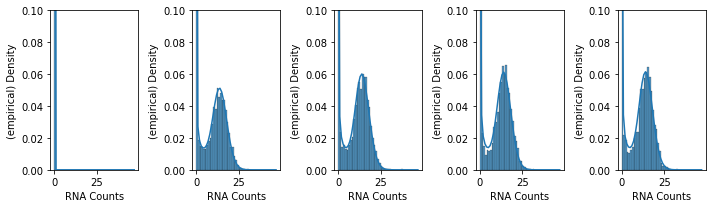

In [ ]:
# Compute the log likelihood of the simulated data given the model
n_fsp=np.max(DataMatrix)+10
LogL = burstingGeneLoglikelihood(K_ON, K_OFF, K_R, GAMMA, observations=DataMatrix, t_measurements=T_MEASUREMENTS, n_fsp=n_fsp)
print(LogL)

# Solve the FSP again so we can plot the results.
x0 = np.array([0,0], dtype="int")
solutions = solveFsp(n_fsp, K_ON, K_OFF, K_R, GAMMA, T_MEASUREMENTS, x0)

# Make plot to compare FSP and SSA results
fig, axs = plt.subplots(1,5)
fig.set_size_inches(10, 3)
fig.set_tight_layout(True)

for i in range(len(T_MEASUREMENTS)):
  RNA_dist = solutions[i][0:n_fsp+1]+solutions[i][n_fsp+1:-1]
  axs[i].plot(RNA_dist)
  sns.histplot(DataMatrix[:,i], bins=range(0,n_fsp), ax=axs[i], stat="density", label="Distribution of Sampled Variables")
  axs[i].set_ylim([0,0.1])
  axs[i].set_xlabel('RNA Counts')
  axs[i].set_ylabel('(empirical) Density')

## Define a Prior on the Parameter Sets: P(Lambda)


In [ ]:
# Define a prior on the parameter sets.
BG_MU = np.array([-1.0, -1.0, 1.0, 0.0])  # mean of prior for parameters in logspace [Kon,Koff,Kr,gamma]
BG_SIGMA = np.array([1., 1., 1., 1.]) # variance of prior for parameters in logspace [Kon,Koff,Kr,gamma]

# Prior density
def bg_prior_sample(n_sample: int, rng=np.random.default_rng()) -> np.ndarray:
    return rng.normal(loc=BG_MU, scale=BG_SIGMA, size=(n_sample, 4))

# Log of prior density
def bg_logprior(parameter: np.ndarray) -> float:
    return -1.0*np.sum((parameter - BG_MU)**2.0/(2*BG_SIGMA**2.0))

## Use MA to estimate the log posterior distribution: P(Lambda|D) = P(D|Lambda)P(Lambda)

In [ ]:
# Define the log(posterior)
def bg_log_target(theta):
  transformed_theta = 10.0**(theta)
  return bg_logprior(theta) + burstingGeneLoglikelihood(*list(transformed_theta), observations=DataMatrix, t_measurements=T_MEASUREMENTS, n_fsp=n_fsp)

# Sample from prior to guess the first point in the chain.
chain_start = [K_ON, K_OFF, K_R, GAMMA] #bg_prior_sample(n_sample=1)

# Call adaptive metropolis algorithm to sample a chain from the log-posterior
bg_chain, bg_logpos = adaptive_metropolis(bg_log_target, start=np.log10(np.array([K_ON, K_OFF, K_R, GAMMA])), 
                                          chain_len=2000, cov_matrix=0.2*np.eye(4))  

100%|██████████| 1999/1999 [03:33<00:00,  9.36it/s, acceptance_rate=0.192]


## Explore the MA Results

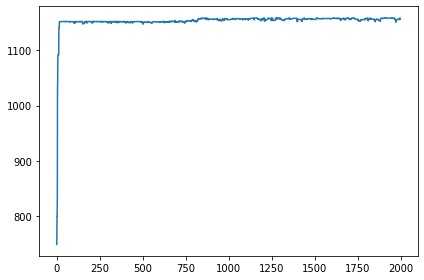

In [ ]:
# Plot the chain of log-likelood values
fig, axs = plt.subplots(1,1)
fig.set_tight_layout(True)
axs.plot(bg_logpos)

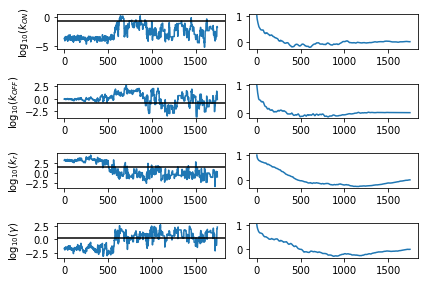

In [ ]:
# Plot the chains of parameter values and their aucorrelation functions.
theta_true = np.log10([K_ON, K_OFF, K_R, GAMMA])
parameter_symbols = [r"$\log_{10}(k_{ON})$", r"$\log_{10}(k_{OFF})$", r"$\log_{10}(k_r)$", r"$\log_{10}(\gamma)$"]

fig, axs = plt.subplots(4, 2)
fig.set_tight_layout(True)
for i in range(4):
  axs[i,0].plot(bg_chain[250:,i])
  axs[i,0].set_ylabel(parameter_symbols[i])
  axs[i,0].axhline(theta_true[i], color='k')
  axs[i,1].plot(emcee.autocorr.function_1d(bg_chain[250:,i]))

In [ ]:
# Estimate the effective sample size
M = 500
AC = emcee.autocorr.function_1d(bg_chain[250:,0])
tau = 1 + 2*sum(AC[:M])
ESS = bg_chain[250:,i].shape[0]/tau
print('Integrated Correlation times: ' + str(tau))
print('Effective Sample Size: ' + str(ESS))

Integrated Correlation times: 125.97731312485361
Effective Sample Size: 13.891390097085257


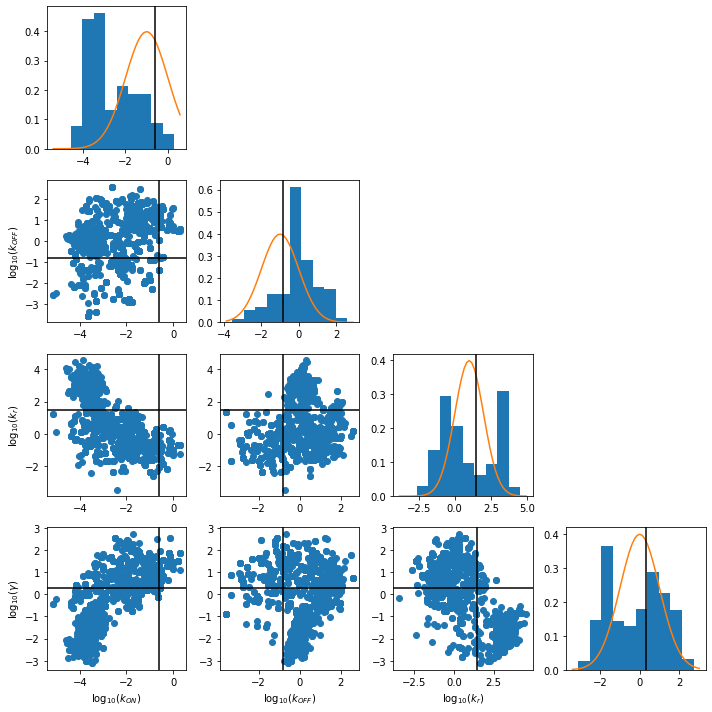

In [ ]:
# Plot the histograms and scatter plots for the sampled posterior distribution.
fig, axs = plt.subplots(4,4)
fig.set_tight_layout(True)
fig.set_size_inches(10, 10)
chain_trunc = bg_chain[100:,:]

theta_true = np.log10([K_ON, K_OFF, K_R, GAMMA])
parameter_symbols = [r"$\log_{10}(k_{ON})$", r"$\log_{10}(k_{OFF})$", r"$\log_{10}(k_r)$", r"$\log_{10}(\gamma)$"]

for i in range(4):
  axs[i,i].hist(chain_trunc[:,i], density=True)   
  xlims = axs[i,i].get_xlim()
  xvals = np.linspace(xlims[0],xlims[1])
  axs[i,i].plot(xvals,stats.norm.pdf(xvals,loc=BG_MU[i],scale=BG_SIGMA[i]))
  axs[i,i].axvline(theta_true[i], color="k")

  for j in range(i):
    axs[i,j].scatter(chain_trunc[:,j], chain_trunc[:,i])
    axs[i,j].axvline(theta_true[j], color="k")
    axs[i,j].axhline(theta_true[i], color="k")
    if j == 0: axs[i,j].set_ylabel(parameter_symbols[i])
    if i == 3: axs[i,j].set_xlabel(parameter_symbols[j])
  for j in range(i+1,4):
    axs[i,j].axis('off')    
  
fig.savefig("mcmc_outputs.png", dpi=400, bbox_inches="tight")

# Beyond this tutorial
Monte Carlo methods is a fast-growing area of research. There are cool topics that are not yet covered in this very elementary tutorial, you are encouraged to look them up after the Summer School. Here are some suggestions:
- [Convergence diagnostics for MCMC.]()
- [Hamiltonian MCMC.](https://arxiv.org/abs/1701.02434)
- [Sequential Monte Carlo.](https://arxiv.org/abs/2007.11936)
- [Approximate Bayesian Computation.](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002803)
- [Pseudo-marginal Metropolis-Hastings.](https://doi.org/10.1016/j.jtbi.2020.110255)
- Other Python-based MCMC libraries. Look for PyStan, PyMC3, EMCEE, TensorFlow Probability.